In [1]:
import pofah.jet_sample as js
import pofah.util.sample_factory as sf
import pofah.util.experiment as ex
import selection.discriminator as dis
import selection.loss_strategy as ls
import analysis.analysis_discriminator as an
import anpofah.util.plotting_util as pu
import pofah.path_constants.sample_dict_file_parts_reco as sd 
import datetime
import dadrah.analysis.root_plotting_util as rpu
from importlib import reload

Welcome to JupyROOT 6.18/04


In [2]:
# read in qcd signal region sample
run_n = 101
SM_sample = 'qcdSigReco'
BSM_samples = ['GtoWW15naReco', 'GtoWW15brReco', 'GtoWW25naReco', 'GtoWW25brReco','GtoWW35naReco', 'GtoWW35brReco', 'GtoWW45naReco', 'GtoWW45brReco']
#BSM_samples = ['GtoWW25naReco', 'GtoWW35naReco', 'GtoWW45naReco']
all_samples = [SM_sample] + BSM_samples
mjj_key = 'mJJ'
reco_loss_j1_key = 'j1RecoLoss'
QR_train_share = 0.2

In [3]:
experiment = ex.Experiment(run_n).setup(analysis_dir=True)
paths = sf.SamplePathDirFactory(sd.path_dict).extend_base_path(experiment.run_dir)
data = sf.read_inputs_to_jet_sample_dict_from_dir(all_samples, paths)

reading /eos/home-k/kiwoznia/dev/autoencoder_for_anomaly/convolutional_VAE/results/run_101/qcd_sqrtshatTeV_13TeV_PU40_parts
reading  /eos/home-k/kiwoznia/dev/autoencoder_for_anomaly/convolutional_VAE/results/run_101/qcd_sqrtshatTeV_13TeV_PU40_parts
num files in dir: 22
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211319 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211319 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 events passed mass cut at 1100.0
211320 eve

split into discriminator train and test-set

In [4]:
# define quantile and loss-strategy for discimination
quantile = 0.1 # 10%
strategy = ls.combine_loss_min
qcd_sig_sample = data[SM_sample]
#split qcd sample into training and testing
qcd_train, qcd_test = js.split_jet_sample_train_test(qcd_sig_sample, QR_train_share)
# update data_dictionary
data[SM_sample] = qcd_test

In [5]:
print(qcd_sig_sample.features())
discriminator = dis.FlatCutDiscriminator(quantile=quantile, loss_strategy=strategy)
discriminator.fit(qcd_train)

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss', 'j1RecoLoss', 'j1KlLoss']


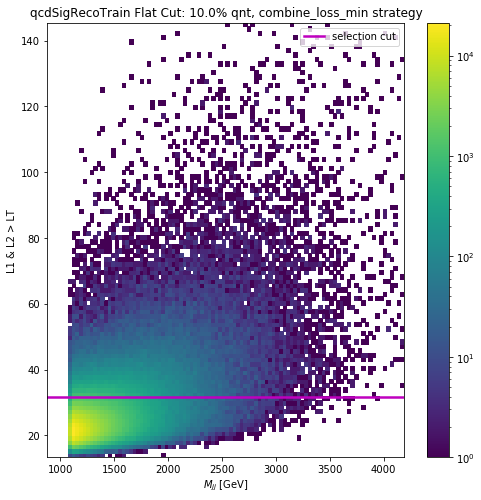

In [6]:
# plot mjj qcd sig to check for flat ratio
an.analyze_discriminator_cut(discriminator, qcd_train)

In [ ]:
date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
model_str = str(QR_train_share)+'_qr_train_'+ str(quantile) +'q_'+ date_str
discriminator.save('models/dnn_run_101_{}.h5'.format(model_str))
print(model_str)

## plot mjj accepted vs rejected signal to check for mass sculpting

### qcd training set

min 1100.0006103515625, max 6613.4990234375


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/QCD_training_set:_BG_like_vs_SIG_like_mjj_distribution_and_their_ratio.jpg has been created


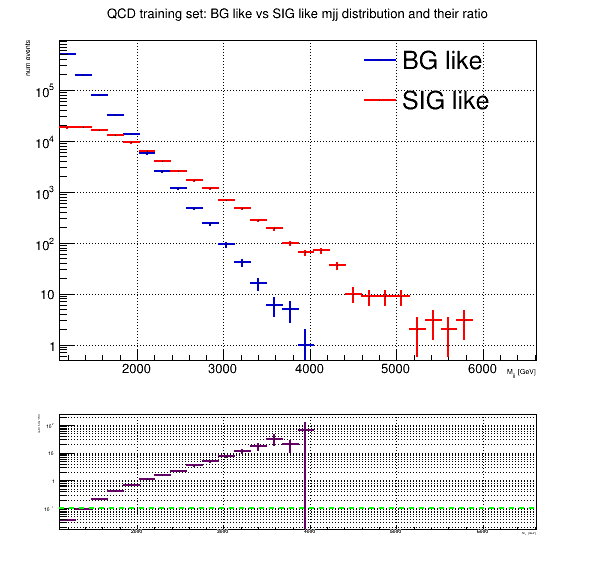

In [7]:
reload(rpu)
selection = discriminator.select(qcd_train)
qcd_train.add_feature('sel', selection)
title = "QCD training set: BG like vs SIG like mjj distribution and their ratio"
h_bg_like_qcd_train, h_sig_like_qcd_train = rpu.make_bg_vs_sig_ratio_plot(qcd_train.rejected(mjj_key), qcd_train.accepted(mjj_key), target_value=quantile, n_bins=30, title=title, fig_dir=experiment.analysis_dir)

### qcd test set

min 1100.0001220703125, max 7338.603515625


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/QCD_test_set:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created


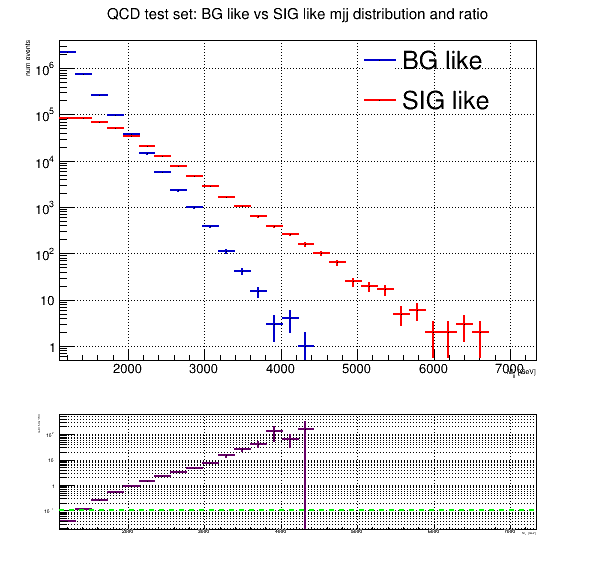

In [8]:
sample = data[SM_sample]
# apply selection to datasample
selection = discriminator.select(sample)
#qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
sample.add_feature('sel', selection)
title = "QCD test set: BG like vs SIG like mjj distribution and ratio"
h_bg_like_qcd_test, h_sig_like_qcd_test = rpu.make_bg_vs_sig_ratio_plot(sample.rejected(mjj_key), sample.accepted(mjj_key), target_value=quantile, n_bins=30, title=title, fig_dir=experiment.analysis_dir)

## check p-value GOF qcd training-set

In [9]:
import dadrah.statistics.hypothesis_test as hypo
reload(hypo)
hypo.hypothesis_test(h_bg_like_qcd_train, h_sig_like_qcd_train, quantile, N_asymov=10000)

S obs: 280.87893868105095
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.


2.2727272727272728e-06

## check p-value GOF qcd test-set

In [10]:
hypo.hypothesis_test(h_bg_like_qcd_test, h_sig_like_qcd_test, quantile, N_asymov=10000)

S obs: 366.21423218345916
90000 0
Increasing by a factor 5 the number of asymov per loop
Will never have enough stat - giving up.


2.2727272727272728e-06

# apply selection

In [11]:
for sample_id in BSM_samples:
    # apply selection to datasample
    selection = discriminator.select(data[sample_id])
    #qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
    data[sample_id].add_feature('sel', selection)

## print efficiency table 

In [12]:
reload(an)
an.print_discriminator_efficiency_table(data)

+---------------+-------------+
|     Sample    | Eff VAE [%] |
+---------------+-------------+
|   qcdSigReco  |     8.95    |
| GtoWW15naReco |     9.65    |
| GtoWW15brReco |     5.57    |
| GtoWW25naReco |     0.87    |
| GtoWW25brReco |     1.10    |
| GtoWW35naReco |     0.23    |
| GtoWW35brReco |     0.44    |
| GtoWW45naReco |     0.08    |
| GtoWW45brReco |     0.26    |
+---------------+-------------+


# plot mjj ratio

min 1100.041015625, max 6007.71630859375
min 1100.0052490234375, max 6969.62890625
min 1100.037841796875, max 5897.4091796875
min 1100.057373046875, max 8607.81640625
min 1100.2769775390625, max 6667.400390625
min 1100.0809326171875, max 8468.8212890625
min 1100.0926513671875, max 7609.75537109375
min 1100.0697021484375, max 8907.7998046875


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/GtoWW15naReco:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/GtoWW15brReco:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/GtoWW25naReco:_BG_like_vs_SIG_like_mjj_distribution_and_ratio.jpg has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: jpg file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/GtoWW25brReco:_BG_like_vs_SIG_like_mjj_dist

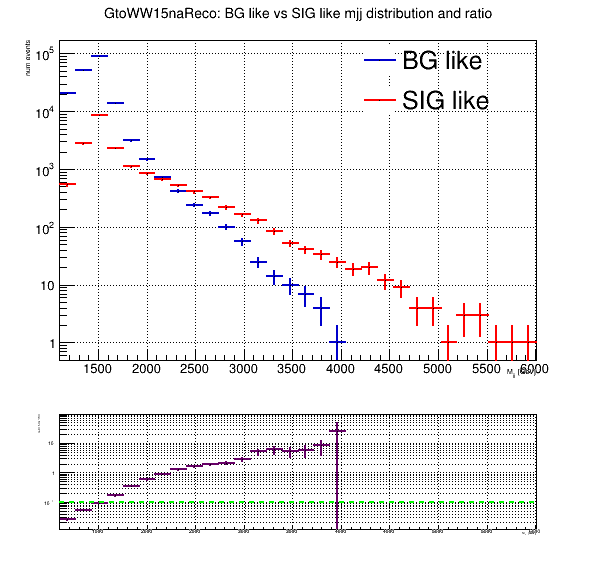

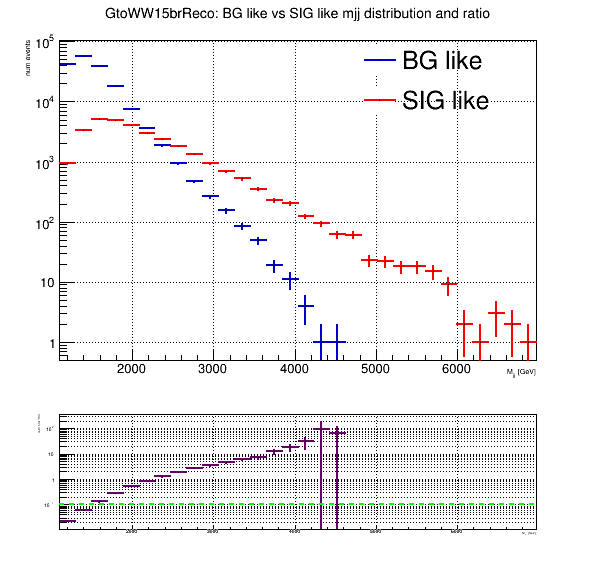

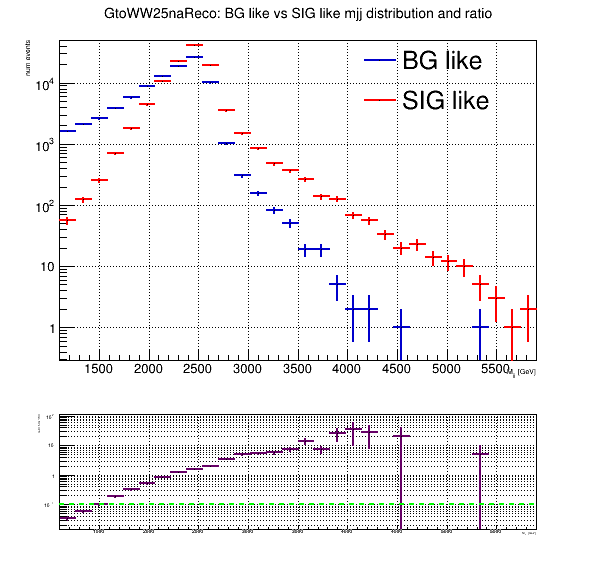

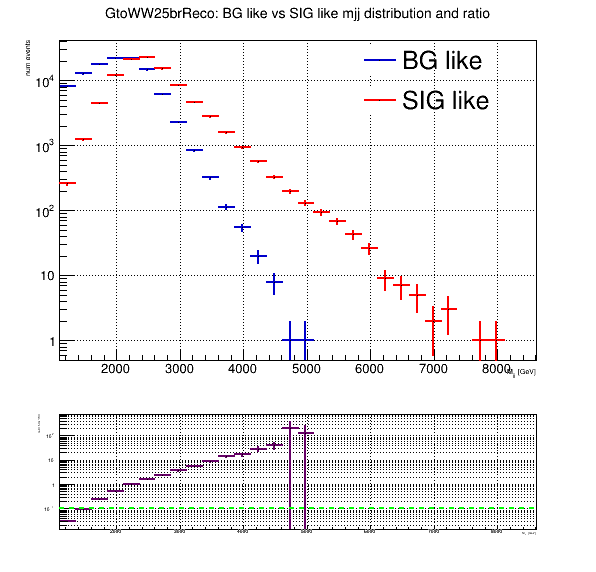

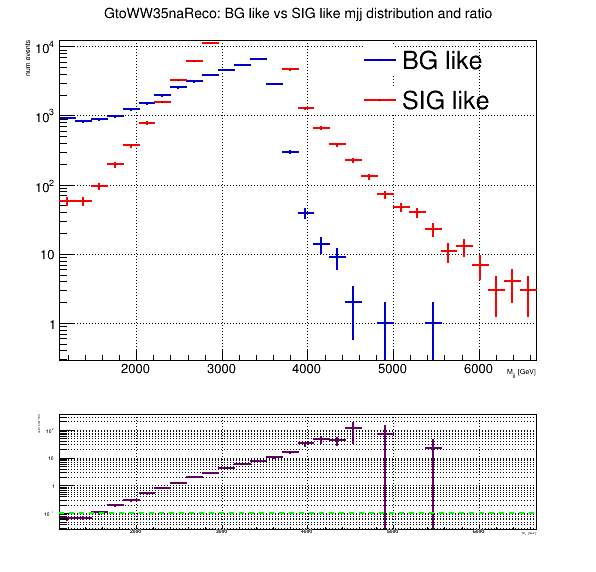

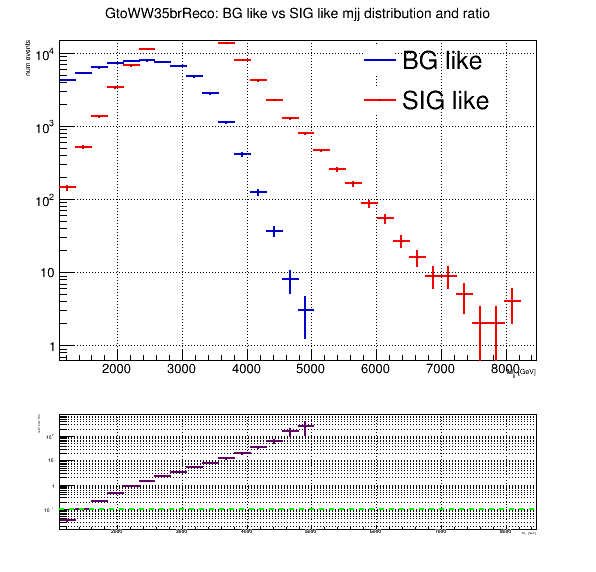

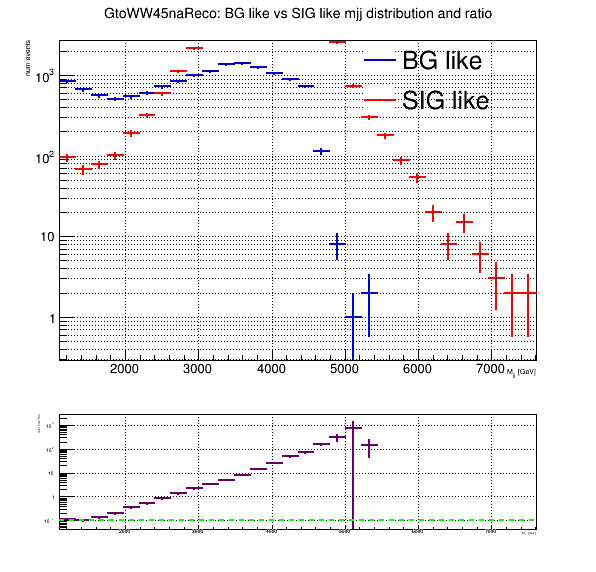

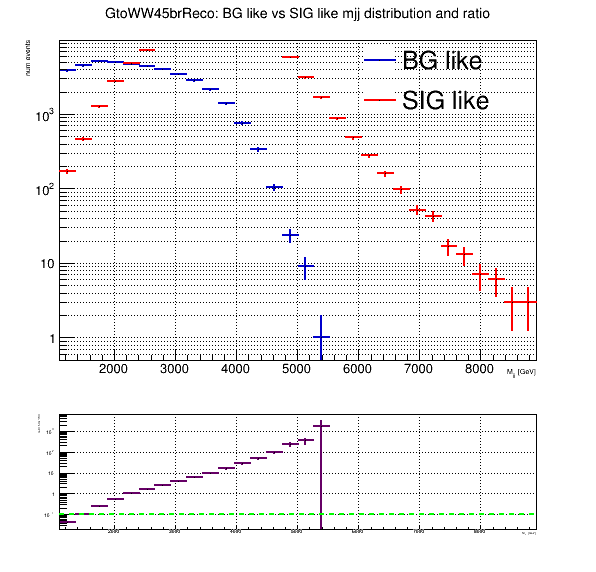

In [13]:
for sample_id in BSM_samples:
    sample = data[sample_id]
    title = sample.name + ": BG like vs SIG like mjj distribution and ratio"
    rpu.make_bg_vs_sig_ratio_plot(sample.rejected(mjj_key), sample.accepted(mjj_key), target_value=quantile, n_bins=30, title=title, fig_dir=experiment.analysis_dir)

## plot losses (reco vs kl) for accepted and rejected sample

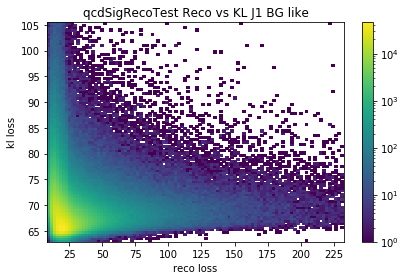

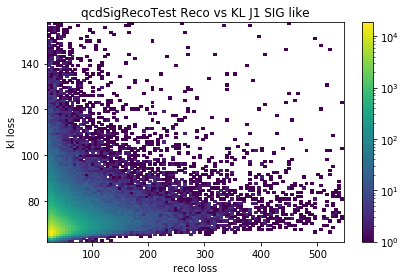

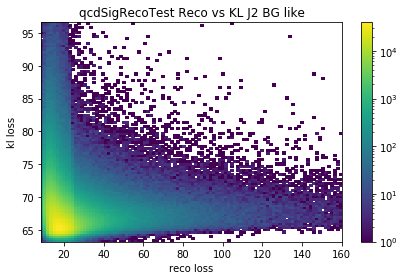

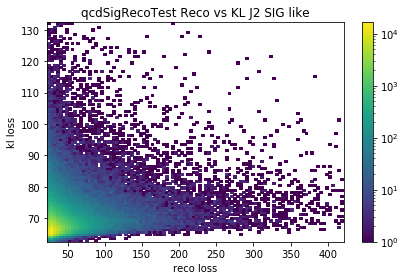

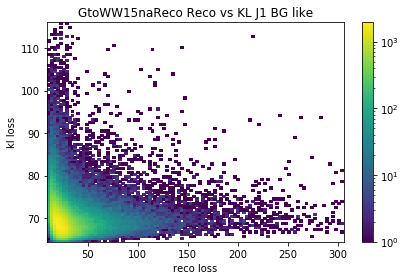

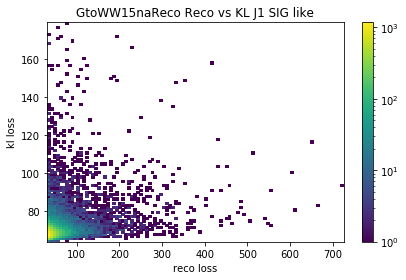

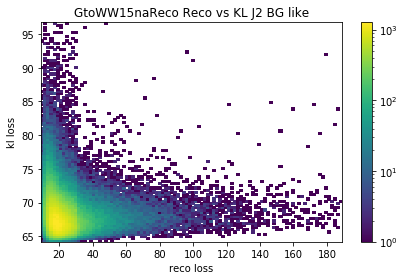

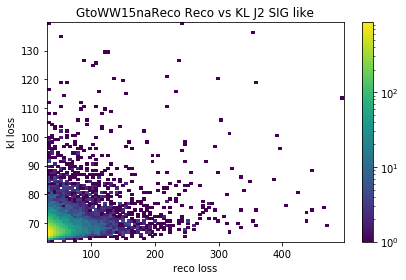

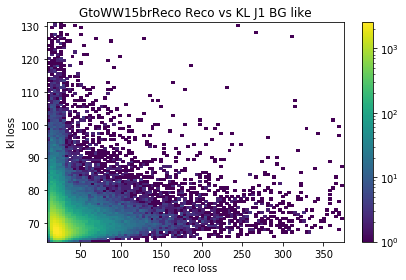

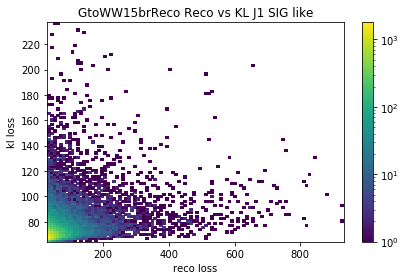

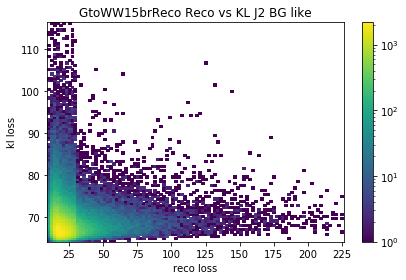

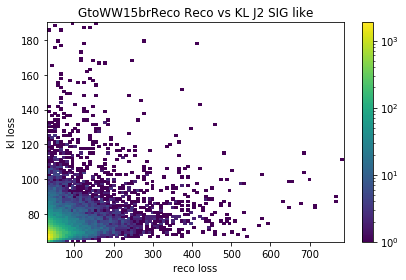

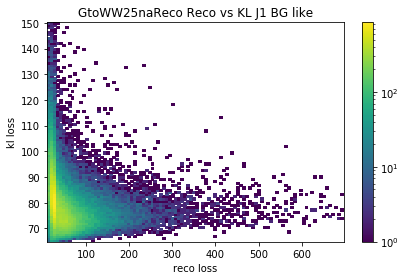

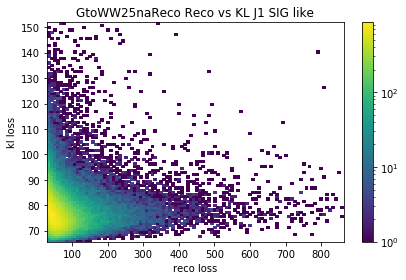

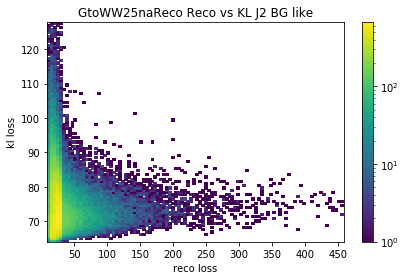

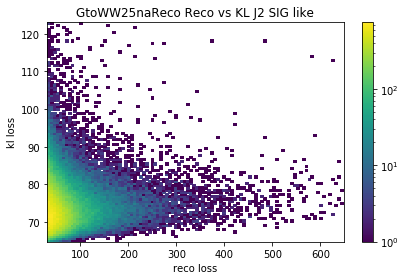

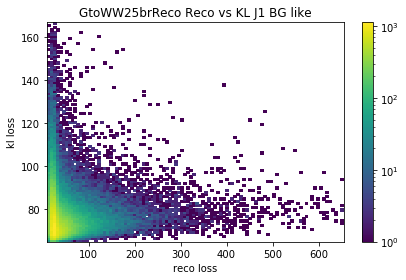

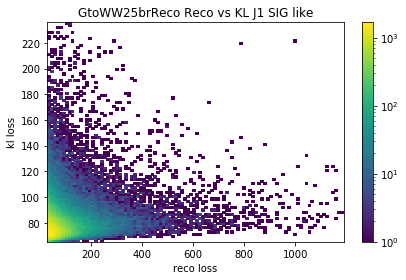

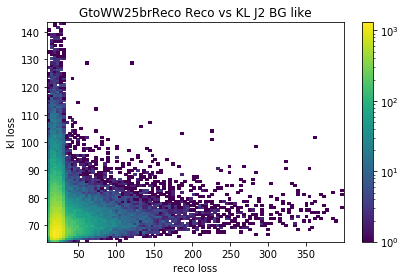

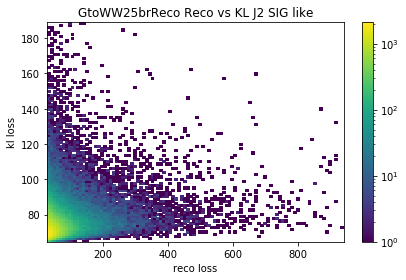

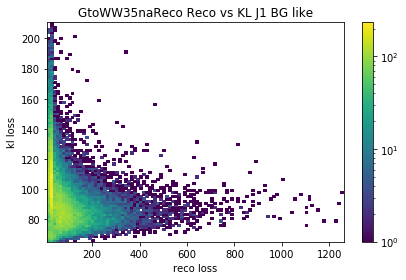

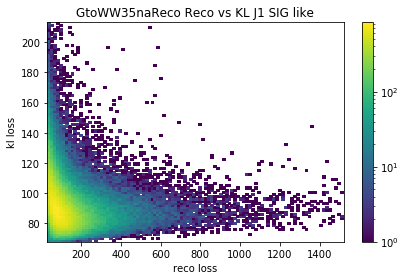

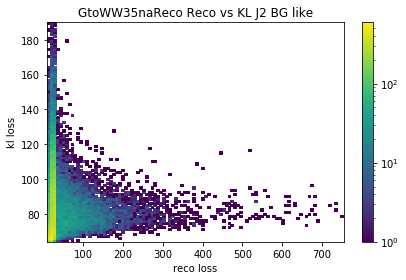

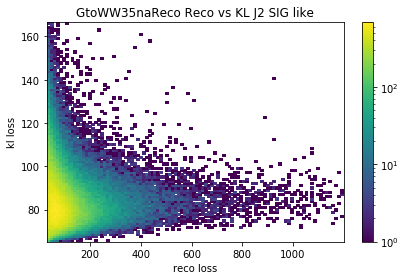

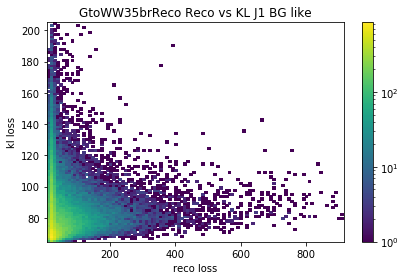

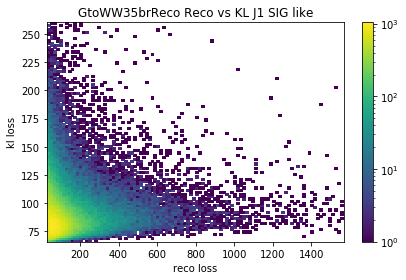

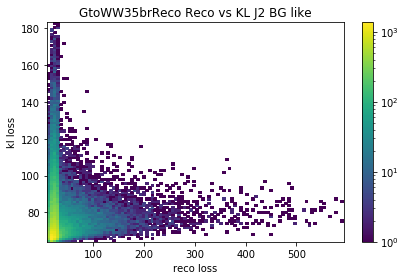

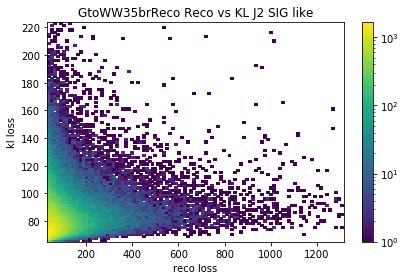

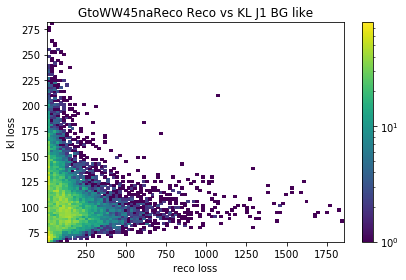

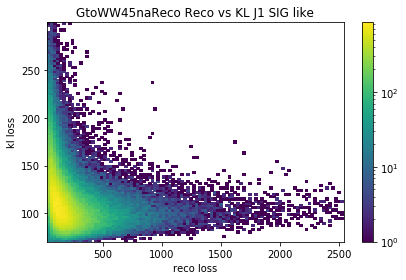

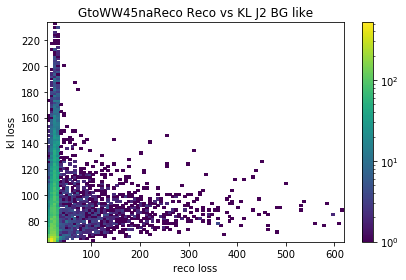

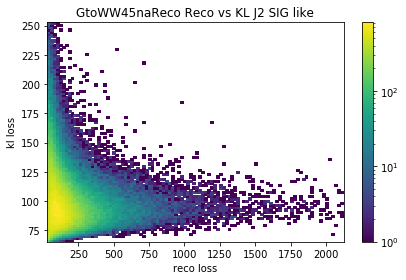

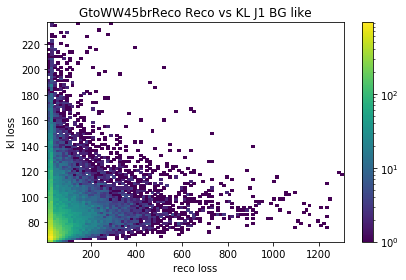

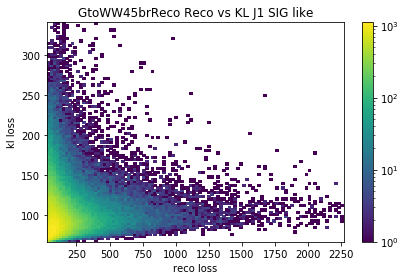

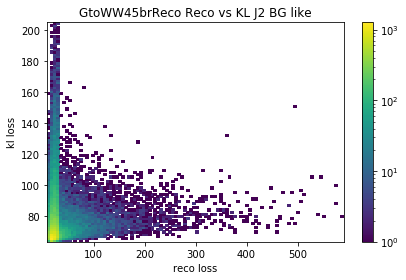

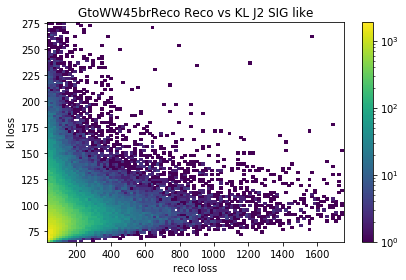

In [14]:
for sample in data.values():
    # plot BG like J1
    pu.plot_hist_2d(sample.rejected('j1RecoLoss'),sample.rejected('j1KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J1 BG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ1_BGlike.png')
    # plot SIG like J1
    pu.plot_hist_2d(sample.accepted('j1RecoLoss'),sample.accepted('j1KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J1 SIG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ1_SIGlike.png')
    # plot BG like J2
    pu.plot_hist_2d(sample.rejected('j2RecoLoss'),sample.rejected('j2KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J2 BG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ2_BGlike.png')
    # plot SIG like J1
    pu.plot_hist_2d(sample.accepted('j2RecoLoss'),sample.accepted('j2KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J2 SIG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ2_SIGlike.png')
    

In [ ]:
print(experiment.analysis_dir)